# Predicting Customer Churn using PySpark

Sparkify is a digital music service where users stream music just like Spotify or Pandora. Users can stream music using a free tier with ads or a paid subscription that has a monthly flat fee with no ads. Service users can upgrade from free tier, downgrade to free tier or Cancel the service.

Our main objective is to identify users who are likely to Cancel the service (churn) and with this the business can offer them discounts and other marketing incentives to keep them in the platform.

The data provided consists of logs that contain user information, demographics and user interactions with the platform.

In [75]:
# import libraries
from pyspark.sql import SparkSession
# create a Spark session
spark = SparkSession.builder.appName("sparkify-churn").getOrCreate()

# import libraries
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_timestamp, count, explode, concat, desc, explode, lit, split, avg, col, concat, desc, explode, lit, split, udf, isnull, min, max
from pyspark.sql import Window

#Machine Learning Libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import datetime as dt
from time import time
import matplotlib.pyplot as plt
import seaborn as sb


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset
The data provided is loaded from an s3 bucket.

Cleaning includes
1. Remove duplicates
2. Remove null or missing Values

In [76]:
path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# path="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

286500

In [78]:
df.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [79]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [80]:
df.take(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Ba

Remove missing values from UserId and SessionId Columns

In [81]:
df = df.dropna(how = "any", subset = ["userId", "sessionId","ts"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remove rowss with empty UsedId 

In [82]:
df = df.filter(df["userId"] != "")
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

278154

Remove any duplicated rows

In [83]:
df.select("userId").dropDuplicates()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[userId: string]

# Exploratory Data Analysis

### Define Churn

We will define churn by labelling the users who have an cancellation service event in their logs

### Explore Data
Exploratory data analysis to observe the behavior for users who stayed vs users who churned. Done by exploring aggregates on these two groups of users

In [84]:
df.select("page").dropDuplicates().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

Add Churn Columns using the Cancellation Confirmation event

In [85]:
churn_indicator = udf(lambda c: 1 if c == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_indication', churn_indicator('page'))

#Add churn columns to indicate users who have churned
windowval = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn_indication').over(windowval))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
df_churn = df.filter('churn == 1')

total_unique_users = df.select("UserId").dropDuplicates().count()
churned_users = df_churn.select("UserId").dropDuplicates().count()
perc_churn = (churned_users/total_unique_users)*100

print('{}% of users Churned'.format(round(perc_churn,0)))
print('The Total Unique Number of Users who have Churned is: {}'.format(total_unique_users))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

23.0% of users Churned
The Total Unique Number of Users who have Churned is: 225

In [62]:
df_churn_by_gender = df.select(["userId", "gender","churn"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
sb.barplot(x='churn', y='count', hue='gender', data=df_churn_by_gender)
plt.title('What is the churn comparison by gender', fontsize= 16);
plt.xlabel('Churn');
plt.ylabel('Number of Users');

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Number of Users')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

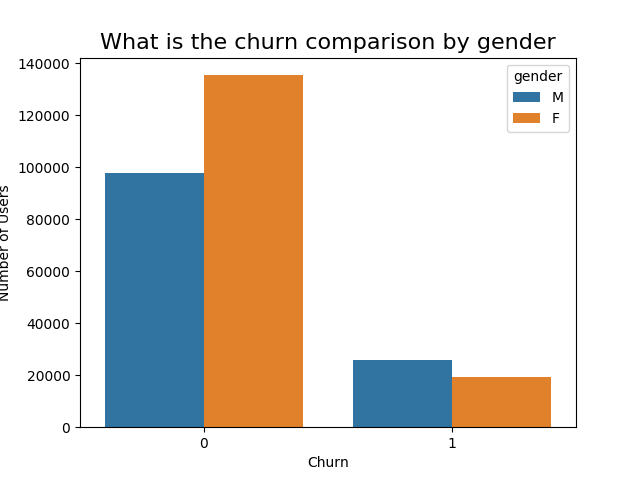

In [64]:
%matplot plt

In [87]:
df = df.withColumn('total_time_days', (df.ts-df.registration)/1000/3600/24)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
total_time_df = df.select('UserId','churn','total_time_days').groupBy('userId','churn').agg(max('total_time_days').alias('total_time')).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
sb.boxplot(data=total_time_df, x='churn', y='total_time', orient='v')
plt.ylabel('Total days');
plt.xlabel('Churned');
plt.title('After how long do Users churn?');

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'After how long do Users churn?')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

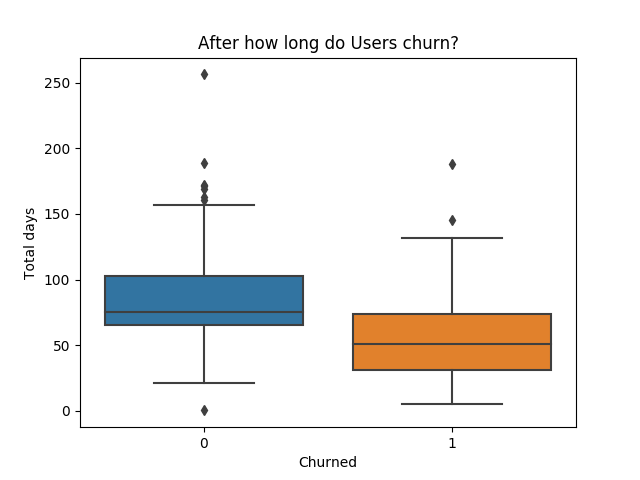

In [90]:
%matplot plt

***Most customers churn after a few days of service usage***

In [91]:
df_churn_by_level = df.select(['userId', 'level','churn']).where(df.churn == 1).groupby(["level"]).count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [92]:
sb.barplot(x='level', y='count',data=df_churn_by_level, color=sb.color_palette()[0]);

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

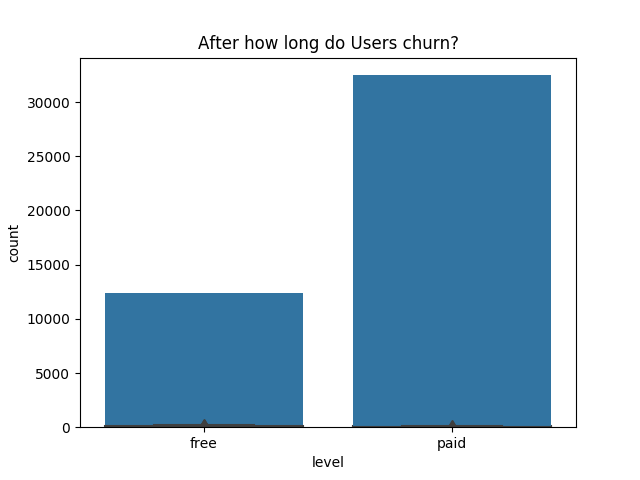

In [93]:
%matplot plt

Generate hour, weekday and day columns

In [33]:
calc_hour = udf(lambda t: dt.datetime.fromtimestamp(t / 1000.0).hour)
df_churn = df_churn.withColumn("ts_hour", calc_hour(df.ts))

calc_weekday = udf(lambda t: dt.datetime.fromtimestamp(t / 1000.0).strftime("%A"))
df_churn = df_churn.withColumn("ts_weekday", calc_weekday(df.ts))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df_churn_by_time = df_churn.select(['userId', 'ts_weekday','ts_hour','churn']).groupby(["userId","ts_weekday","ts_hour"]).agg(count(df.userId).alias('count'))#.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
df_churn_by_hr_week = df_churn_by_time.groupBy('ts_hour').pivot('ts_weekday').sum('count').sort('ts_hour')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df_churn_by_hr_week = df_churn_by_hr_week.withColumn('ts_hour',df_churn_by_hr_week.ts_hour.cast('int'))
df_churn_by_hr_week = df_churn_by_hr_week.toPandas().set_index('ts_hour').sort_index(axis=0,ascending=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [164]:
plt.figure(figsize=(16,10))
sb.heatmap(df_churn_by_hr_week, fmt='d',  cmap='viridis_r', annot_kws={"size": 12},  cbar_kws={'label': 'Number of Churns'})
plt.title("Which Hour and Day has High Customer Churn?", y=1, fontsize=18)
plt.xlabel('Day of the week', labelpad=8)
plt.ylabel('Hour (24hr)', labelpad=8)
plt.yticks(rotation=360);

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5]), <a list of 24 Text yticklabel objects>)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

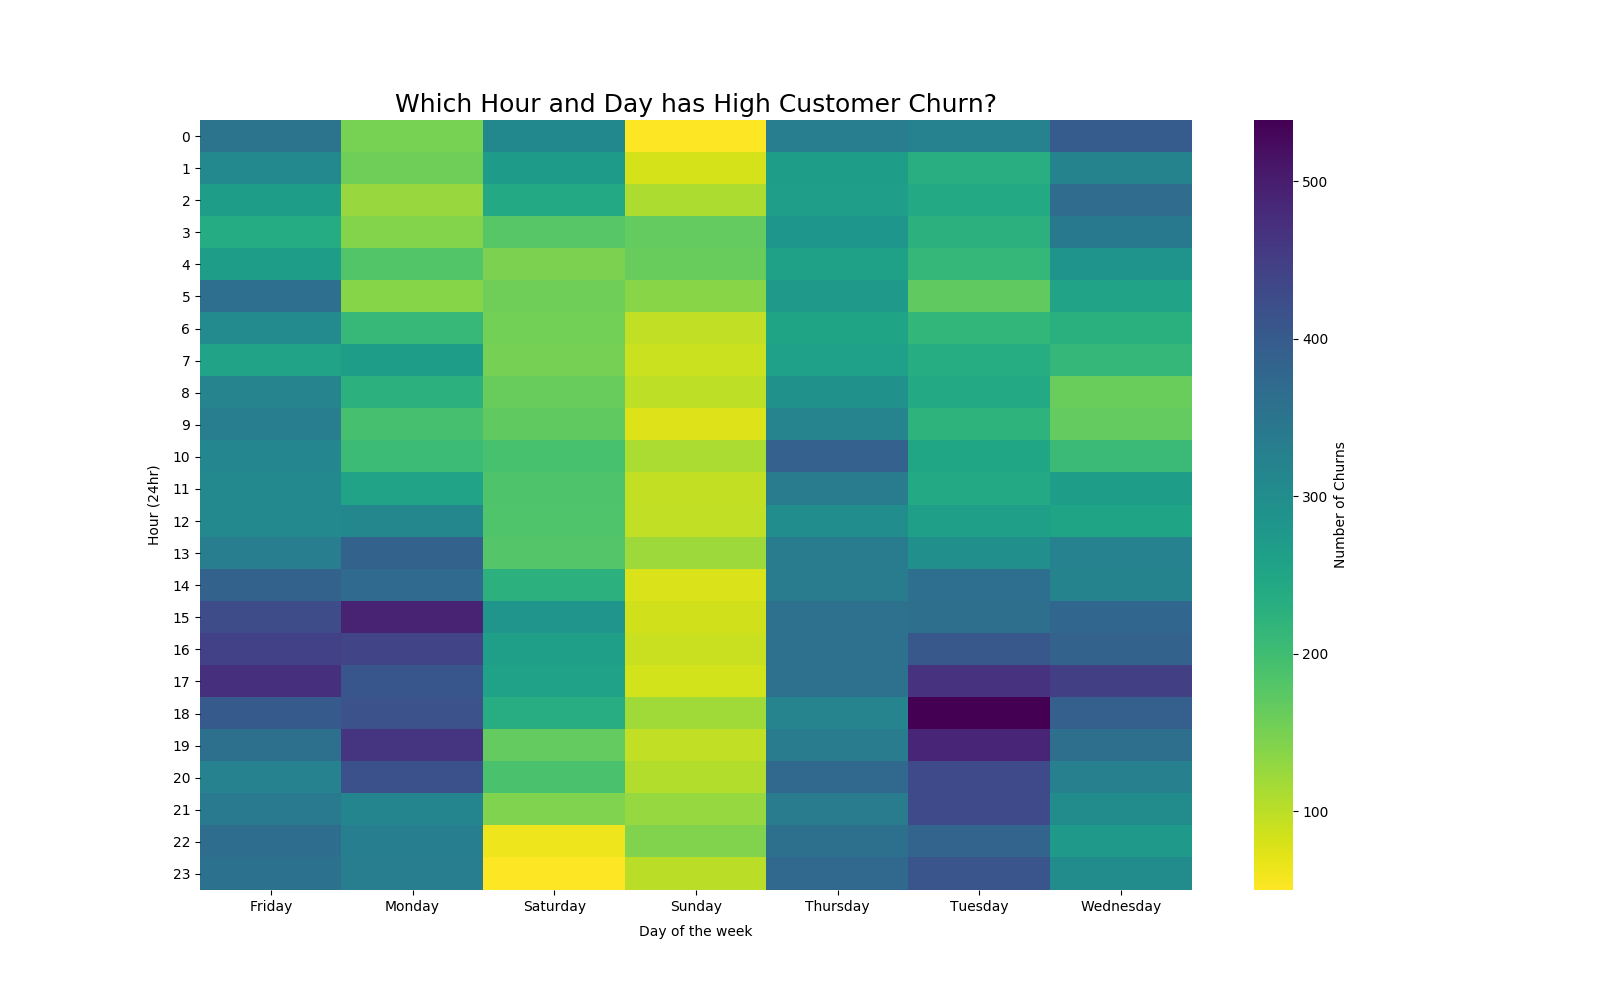

In [165]:
%matplot plt

Most Customer churns occur during **week days** between **1300 hours** and **2100 hours.**

# Feature Engineering


1. Gender Feature

In [29]:
gender_ft = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
gender_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.4622222222222222|
| stddev|105396.47791907168|0.4996824388374476|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+

2. Paid of free tier subscription feature

In [30]:
level_ft = df.select("userId", "level").dropDuplicates().replace(['free', 'paid'], ['0', '1'], 'level').select('userId', col('level').cast('int'))
level_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-------------------+
|summary|            userId|              level|
+-------+------------------+-------------------+
|  count|               360|                360|
|   mean| 64780.23888888889| 0.4583333333333333|
| stddev|106080.85223362078|0.49895433834658137|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+

3. Total Time of User on platform - days

In [31]:
total_time_ft = df.select('UserId','total_time_days').groupBy('userId').agg(max('total_time_days').alias('total_time'))
total_time_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-------------------+
|summary|            userId|         total_time|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|  79.84568348765433|
| stddev| 105396.4779190716|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+

4. Total Number of songs a user has listened to

In [32]:
total_songs_ft = df.select('UserId','song').groupBy('userId').agg(count('UserId').alias('total_songs'))
total_songs_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            userId|       total_songs|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|           1236.24|
| stddev|105396.47791907164|1329.5317164325193|
|    min|                10|                 6|
|    max|                99|              9632|
+-------+------------------+------------------+

5. Number of songs per session

In [33]:
songs_per_session_ft = df.filter(df.page=="NextSong").groupBy('UserId','sessionId').count().groupBy('userId').agg(avg('count').alias('songs_per_session'))
songs_per_session_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+
|summary|            userId|songs_per_session|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958934|
| stddev|105396.47791907165| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+

6. Total number of artists a user has listened to

In [34]:
total_artists_ft = df.filter(df.page=="NextSong").select('UserId','artist').dropDuplicates().groupBy('userId').agg(count('UserId').alias('total_artists'))
total_artists_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+
|summary|            userId|    total_artists|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907165|603.9518698630807|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+

7. Total Length of listening

In [35]:
total_listening_ft = df.select('UserId','length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_listen_time')
total_listening_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            userId| total_listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155552|
| stddev|105396.47791907164| 275396.4038847639|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799998|
+-------+------------------+------------------+

Some more features based to Page logs

8. Number of friends Added 

In [36]:
friends_added_ft = df.filter(df.page=="Add Friend").groupBy('userId').agg(count('UserId').alias('friends_added'))
friends_added_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            userId|     friends_added|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+

9. Help page access

In [37]:
help_ft = df.filter(df.page=="Help").groupBy('UserId').agg(count('UserId').alias('help_access'))
help_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+
|summary|            UserId|      help_access|
+-------+------------------+-----------------+
|  count|               192|              192|
|   mean| 67244.30208333333|7.572916666666667|
| stddev|107862.22540637234|7.284416115934567|
|    min|                10|                1|
|    max|                99|               46|
+-------+------------------+-----------------+

10. Number of songs added to Playlist

In [38]:
songs_playlist_ft = df.filter(df.page=="Add to Playlist").groupBy('UserId').agg(count('UserId').alias('songs_on_playlist'))
songs_playlist_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            UserId| songs_on_playlist|
+-------+------------------+------------------+
|  count|               215|               215|
|   mean| 66103.63720930232| 30.35348837209302|
| stddev|106360.47999565043|32.852056855599706|
|    min|                10|                 1|
|    max|                99|               240|
+-------+------------------+------------------+

11. Number of Thumps Up - Likes

In [39]:
likes_ft = df.filter(df.page=="Thumbs Up").groupBy('UserId').agg(count('UserId').alias('likes'))
likes_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----------------+
|summary|            UserId|            likes|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121884|65.67028650524045|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+

12. Number of Thumps Down - dislikes

In [40]:
dislikes_ft = df.filter(df.page=="Thumbs Down").groupBy('UserId').agg(count('UserId').alias('dislikes'))
dislikes_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+
|summary|           UserId|          dislikes|
+-------+-----------------+------------------+
|  count|              203|               203|
|   mean|66066.16256157635|12.541871921182265|
| stddev|106108.3256989378|13.198108566983786|
|    min|               10|                 1|
|    max|               99|                75|
+-------+-----------------+------------------+

13. Churn Label 

In [41]:
churn_label_ft = df.select('UserId', col('churn').alias('label')).dropDuplicates()
churn_label_ft.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+
|summary|            UserId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+

In [42]:
#combine all datasources into a single data frame
feature_df = gender_ft.join(level_ft,'userID','outer') \
    .join(total_time_ft,'userID','outer') \
    .join(total_songs_ft,'userID','outer') \
    .join(total_artists_ft,'userID','outer') \
    .join(songs_per_session_ft,'userID','outer') \
    .join(total_listening_ft,'userID','outer') \
    .join(friends_added_ft,'userID','outer') \
    .join(help_ft,'userID','outer') \
    .join(songs_playlist_ft,'userID','outer') \
    .join(likes_ft,'userID','outer') \
    .join(dislikes_ft,'userID','outer') \
    .join(churn_label_ft,'userID','outer')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
feature_df = feature_df.drop('userID').na.fill(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
feature_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['gender', 'level', 'total_time', 'total_songs', 'total_artists', 'songs_per_session', 'total_listen_time', 'friends_added', 'help_access', 'songs_on_playlist', 'likes', 'dislikes', 'label']

In [45]:
feature_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+------------------+-----------+-------------+------------------+------------------+-------------+-----------+-----------------+-----+--------+-----+
|gender|level|        total_time|total_songs|total_artists| songs_per_session| total_listen_time|friends_added|help_access|songs_on_playlist|likes|dislikes|label|
+------+-----+------------------+-----------+-------------+------------------+------------------+-------------+-----------+-----------------+-----+--------+-----+
|     1|    0|  55.6436574074074|        381|          252|39.285714285714285|       66940.89735|            4|          2|                7|   17|       5|    0|
|     0|    0| 70.07462962962963|        474|          339|              64.5| 94008.87593999993|            4|          2|                8|   21|       6|    0|
|     0|    1| 70.07462962962963|        474|          339|              64.5| 94008.87593999993|            4|          2|                8|   21|       6|    0|
|     0|    0| 71.3168

# Modeling
Involves:
1. splitting the full dataset into train, test, and validation sets. 
2. Testing out several of the machine learning methods. 
3. Model Evaluation using accuracy score and f1 score
4.  Tuning

Vectorize and standardize out features

In [46]:
#Vectorize features
cols = ['gender', 'level', 'total_time', 'total_songs', 'total_artists', 'songs_per_session', 'total_listen_time', 'friends_added', 'help_access', 'songs_on_playlist', 'likes', 'dislikes']
assembler = VectorAssembler(inputCols=cols, outputCol="vfeatures")
data = assembler.transform(feature_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# standardize features
scaler = StandardScaler(inputCol="vfeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Split data into Train, Validation and Test usind randomSplit function

In [48]:
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Model Training

##### Logistic Regression

In [50]:
#estimator
lr = LogisticRegression(maxIter=10)
#evaluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
# build an empty paramGrid for now
paramGrid = ParamGridBuilder().build()

lr_cv = CrossValidator(estimator=lr,
                          evaluator=mce_f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
lr_cv_model = lr_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
lr_results = lr_cv_model.transform(validation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(lr_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-72:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 30229



F1 Score:0.8205128205128205
Accuracy Score:0.825

##### Support Vector machines


In [54]:
#estimator
svm = LinearSVC(maxIter=10)
#evluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
# build an empty paramGrid for now
paramGrid = ParamGridBuilder().build()

svm_cv = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=mce_f1_evaluator,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
svm_model = svm_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-51:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1598



In [56]:
svm_results = svm_model.transform(validation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(svm_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(svm_results, {evaluator.metricName: "accuracy"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-71:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 30077



F1 Score:0.7111111111111111
Accuracy Score:0.8

##### Random Forest Classifier

In [58]:
#classifier
rf = RandomForestClassifier()

#evaluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build an empty paramGrid for now
paramGrid = ParamGridBuilder().build()

rf_cv = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=mce_f1_evaluator,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
rf_model = rf_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-55:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5736



In [60]:
rf_results = rf_model.transform(validation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(rf_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(rf_results, {evaluator.metricName: "accuracy"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score:0.8415584415584416
Accuracy Score:0.85

##### gradient boosted trees

In [66]:
#classifier
gbt = GBTClassifier(maxIter=10,seed=42)

#evaluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build an empty paramGrid for now
paramGrid = ParamGridBuilder().build()

gbt_cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=mce_f1_evaluator,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
gbt_model = gbt_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-63:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 18766



In [70]:
gbt_results = gbt_model.transform(validation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score:0.903942652329749
Accuracy Score:0.9

The overall results are as below

In [88]:
score = [('Logistic Regression',0.82,0.82),
('Support Vector Machine',0.71,0.80),
('Random Forest Classifier',0.84,0.85),
('Gradient Boost Trees',0.90,0.9)]
label=['Classifier','F1 Score', 'Accuracy Score']

score_df = pd.DataFrame(data=score, columns=label)#.set_index('Classifier')
spark.createDataFrame(score_df).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+--------------+
|          Classifier|F1 Score|Accuracy Score|
+--------------------+--------+--------------+
| Logistic Regression|    0.82|          0.82|
|Support Vector Ma...|    0.71|           0.8|
|Random Forest Cla...|    0.84|          0.85|
|Gradient Boost Trees|     0.9|           0.9|
+--------------------+--------+--------------+

#### Hyper parameter tunning

In [116]:
# {param[0].name: param[1] for param in gbt.extractParamMap().items()}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
gbt = GBTClassifier(maxIter=10,seed=42)

# build param Grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5, 10,15]) \
    .addGrid(gbt.maxDepth,[2,3,4,5,6,7,8]) \
    .build()
# set evaluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

gbt_hpt_cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=mce_f1_evaluator,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
gbt_hpt_model = gbt_hpt_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
gbt_model_results = gbt_hpt_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'gbt_model' is not defined
Traceback (most recent call last):
NameError: name 'gbt_model' is not defined



In [110]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(gbt_model_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(gbt_model_results, {evaluator.metricName: "accuracy"})))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score:0.7770666666666667
Accuracy Score:0.78

In [126]:
# {param[0].name: param[1] for param in rf.extractParamMap().items()}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
#classifier
rf = RandomForestClassifier()

#evaluator
mce_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build an empty paramGrid for now
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2,3,4,5,6,7,8]) \
    .build()

rf_cv = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=mce_f1_evaluator,
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
# gbt.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-110:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 639635



In [119]:
rf_model = rf_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [120]:
rf_model_results = rf_model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [124]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('F1 Score:{}'.format(evaluator.evaluate(rf_model_results, {evaluator.metricName: "f1"})))
print('Accuracy Score:{}'.format(evaluator.evaluate(rf_model_results, {evaluator.metricName: "accuracy"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score:0.841720430107527
Accuracy Score:0.85

Randomforest Classifier score the highest on the test data set after parameter tuning as compared to Gradient . When considering time as a metric , it also takes lesser time to train. Therefore out of the four algorithms Random forest is the most robust

## Conclusion

I started by loading the data, removing missing values, removing duplicated data, creating additional columns for data exploration and answered a few business questions using visuals. Then dived into feature generation and modelling. The most interesting and difficult bit of the project is implementation of spark Ml, using PySpark to preporcess and feature engineer data; considering this is the first time hands on with the tool. It is a great skill addition to be able to deploy ML solutions on the cloud in this case, AWS EMR service.

## Improvement
The other challenging part is feature generation where i could only come up with 12 features. With a bigger dataset and more features the models could be more accurate in predicting Customer churn

